In [1]:
%pylab inline
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import sys

import numpy as np
import pandas as pd
import scanpy as sc #for interface to single cell stuff

import tensorflow as tf
import tensorflow_probability as tfp
import arviz as az
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.font_manager as fm

rcParams['font.family'] = 'sans-serif'

sys.path.append('../')
from mederrata_spmf import PoissonMatrixFactorization

# load the data
dataset_name = 'pbmc3k'
#datapath="C:\\data\\scRNAseq\\" + dataset_name + "\\"
datapath="./"
X = np.load(datapath + dataset_name + '_counts.npy')
gene_names = np.load(datapath + dataset_name + '_genenames.npy', allow_pickle=True)
UMAP =  np.load(datapath + dataset_name + '_UMAP.npy')

P = 2

N_BATCHES = 4
BATCH_SIZE = int(np.floor(X.shape[0]/N_BATCHES))

# normalization for cells, computed using all genes
counts_per_cell = X.sum(1)
after = np.median(np.array(counts_per_cell))
# after=1e4
size_factors = counts_per_cell / after
norm_vals = size_factors

# keep the first D genes
# X = X[:, :D]
# gene_names=gene_names[:D]

#alternative: specify a list of known cell type markers
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']
hvgix = pd.Series(gene_names).isin(marker_genes)
X = X[:, hvgix]
gene_names=gene_names[hvgix]

N, D = X.shape
# print(X.shape)
print(f"Total observations={X.shape[0]}, Batch size={BATCH_SIZE}: dropping {X.shape[0]%BATCH_SIZE} observations.")

# Test taking in from tf.dataset, don't pre-batch
data = tf.data.Dataset.from_tensor_slices(
    {
        'data': X,
        'indices': np.arange(N),
        'normalization': norm_vals
    })

# data = data.shuffle(buffer_size=N+1)
data = data.batch(BATCH_SIZE, drop_remainder=True)

# strategy = tf.distribute.MirroredStrategy()
    # encoder_function=lambda x: tf.math.log(x+1), decoder_function=lambda x: tf.math.exp(x)-1,
    # encoder_function=lambda x: x, decoder_function=lambda x: x,
strategy = None
factor = PoissonMatrixFactorization(
    data, latent_dim=P, strategy=strategy,
    scale_rates=True, 
    u_tau_scale=1.0/np.sqrt(D*N),
    dtype=tf.float64)


Populating the interactive namespace from numpy and matplotlib
Total observations=2638, Batch size=659: dropping 2 observations.
Feature dim: 17 -> Latent dim 2


In [2]:
losses = factor.calibrate_advi(
    num_epochs=1000, learning_rate=.1, max_decay_steps=100)

waic = factor.waic()

W0604 09:09:54.299687 4688403904 deprecation.py:506] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/resource_variable_ops.py:1817: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Initial loss: 52.51914728268064
Epoch 1: average-batch loss: 51.587393992968416 last batch loss: 52.460681994501236
Saved a checkpoint: ./.tf_ckpts/chkpt-1
Epoch 2: average-batch loss: 51.464534476007586 last batch loss: 52.34520589914621
Saved a checkpoint: ./.tf_ckpts/chkpt-2
Epoch 3: average-batch loss: 51.36326347029604 last batch loss: 52.21081804100364
Saved a checkpoint: ./.tf_ckpts/chkpt-3
Epoch 4: average-batch loss: 51.3268315276477 last batch loss: 52.19617347311315
Saved a checkpoint: ./.tf_ckpts/chkpt-4
Epoch 5: average-batch loss: 51.26310696290052 last batch loss: 52.160840186625755
Saved a checkpoint: ./.tf_ckpts/chkpt-5
Epoch 6: average-batch loss: 51.19463632462846 last batch loss: 52.072721261764556
Saved a checkpoint: ./.tf_ckpts/chkpt-6
Epoch 7: average-batch loss: 51.16930265712551 last batch loss: 52.04578634404835
Saved a checkpoint: ./.tf_ckpts/chkpt-7
Epoch 8: average-batch loss: 51.10799961350996 last batch loss: 52.02337018761944
Saved a checkpoint: ./.tf_ck

Epoch 69: average-batch loss: 29.219388029604076 last batch loss: 30.166082918477013
Saved a checkpoint: ./.tf_ckpts/chkpt-68
Epoch 70: average-batch loss: 29.22218991514376 last batch loss: 30.15175102144559
Epoch 71: average-batch loss: 29.201610642390165 last batch loss: 30.121998123590576
Saved a checkpoint: ./.tf_ckpts/chkpt-69
Epoch 72: average-batch loss: 29.17428129262222 last batch loss: 30.092056852490796
Saved a checkpoint: ./.tf_ckpts/chkpt-70
Epoch 73: average-batch loss: 29.17264671549893 last batch loss: 30.12192553310153
Saved a checkpoint: ./.tf_ckpts/chkpt-71
Epoch 74: average-batch loss: 29.160743013011995 last batch loss: 30.106427096621484
Saved a checkpoint: ./.tf_ckpts/chkpt-72
Epoch 75: average-batch loss: 29.150819157388224 last batch loss: 30.079674071198635
Saved a checkpoint: ./.tf_ckpts/chkpt-73
Epoch 76: average-batch loss: 29.13565599746729 last batch loss: 30.043326260952217
Saved a checkpoint: ./.tf_ckpts/chkpt-74
Epoch 77: average-batch loss: 29.122519

Epoch 141: average-batch loss: 29.020178257668803 last batch loss: 29.97124159156316
We are in a loss plateau learning rate: 0.03874204890000001 loss: 29.572049602178275
Restoring from a checkpoint - loss: 29.581584534342415
Epoch 142: average-batch loss: 28.997937828577832 last batch loss: 29.9424461602756
Saved a checkpoint: ./.tf_ckpts/chkpt-94
Epoch 143: average-batch loss: 29.01462050858227 last batch loss: 29.96654575303251
Epoch 144: average-batch loss: 29.01476424947457 last batch loss: 29.950446278245593
Epoch 145: average-batch loss: 29.011086513604845 last batch loss: 29.970083496333416
Epoch 146: average-batch loss: 28.998074773790645 last batch loss: 29.94490908758408
Epoch 147: average-batch loss: 29.012739255214008 last batch loss: 29.975004368822617
We are in a loss plateau learning rate: 0.03486784401000001 loss: 29.577001450511766
Restoring from a checkpoint - loss: 29.592366933857576
Epoch 148: average-batch loss: 29.008833432827803 last batch loss: 29.94428923071668

Epoch 219: average-batch loss: 28.990930807045864 last batch loss: 29.939641681951336
Epoch 220: average-batch loss: 28.99087822685331 last batch loss: 29.94363881679835
Epoch 221: average-batch loss: 29.003481665909657 last batch loss: 29.94411396179119
We are in a loss plateau learning rate: 0.010941898913151242 loss: 29.59117753368246
Restoring from a checkpoint - loss: 29.571313642953594
Epoch 222: average-batch loss: 28.981951359656126 last batch loss: 29.922801828327316
Epoch 223: average-batch loss: 29.002199030605755 last batch loss: 29.93653171725265
Epoch 224: average-batch loss: 28.985216805562644 last batch loss: 29.94054537927979
Epoch 225: average-batch loss: 28.99452805485832 last batch loss: 29.939698622339954
Epoch 226: average-batch loss: 28.99535439732322 last batch loss: 29.9468952451118
We are in a loss plateau learning rate: 0.00984770902183612 loss: 29.569252863711778
Restoring from a checkpoint - loss: 29.56808844864688
Epoch 227: average-batch loss: 28.98908151

Epoch 299: average-batch loss: 28.985526444856045 last batch loss: 29.93250742142004
We are in a loss plateau learning rate: 0.003090315438263264 loss: 29.56831169224568
Restoring from a checkpoint - loss: 29.563614354490337
Epoch 300: average-batch loss: 28.994451476667837 last batch loss: 29.945130634387926
Epoch 301: average-batch loss: 28.997018447196197 last batch loss: 29.939715472465505
Epoch 302: average-batch loss: 28.990090921775426 last batch loss: 29.954050119233585
Epoch 303: average-batch loss: 28.990119230948967 last batch loss: 29.928733680517105
Epoch 304: average-batch loss: 28.994945742283363 last batch loss: 29.951853261554625
We are in a loss plateau learning rate: 0.0027812838944369376 loss: 29.58664452841003
Restoring from a checkpoint - loss: 29.55546408656632
Epoch 305: average-batch loss: 28.99331853677029 last batch loss: 29.958161284564554
Epoch 306: average-batch loss: 28.97808967728851 last batch loss: 29.948943203354784
Epoch 307: average-batch loss: 28.9

Epoch 376: average-batch loss: 28.991816192025684 last batch loss: 29.935317774594466
Epoch 377: average-batch loss: 28.98055378079313 last batch loss: 29.956064739557476
Epoch 378: average-batch loss: 28.99289855972974 last batch loss: 29.934440098585686
We are in a loss plateau learning rate: 0.0008727963568087723 loss: 29.5532601379339
Restoring from a checkpoint - loss: 29.535633099100707
Epoch 379: average-batch loss: 28.9716368472808 last batch loss: 29.930565467746163
Saved a checkpoint: ./.tf_ckpts/chkpt-103
Epoch 380: average-batch loss: 28.988181031820723 last batch loss: 29.928620988566266
Epoch 381: average-batch loss: 29.00372121866586 last batch loss: 29.973169278809056
Epoch 382: average-batch loss: 28.986536931392237 last batch loss: 29.945745169537705
Epoch 383: average-batch loss: 28.978085693881606 last batch loss: 29.91518821356644
Epoch 384: average-batch loss: 28.98906985307861 last batch loss: 29.935138487811518
We are in a loss plateau learning rate: 0.000785516

Epoch 457: average-batch loss: 28.975002312878615 last batch loss: 29.933482170260064
Epoch 458: average-batch loss: 28.996424662224555 last batch loss: 29.939645250368738
Epoch 459: average-batch loss: 28.99322518081518 last batch loss: 29.927898859382704
Epoch 460: average-batch loss: 28.987549289160324 last batch loss: 29.95091219888405
Epoch 461: average-batch loss: 28.97765508376817 last batch loss: 29.9418822015617
Epoch 462: average-batch loss: 28.9886813118966 last batch loss: 29.940326905714272
We are in a loss plateau learning rate: 0.0002465034704958071 loss: 29.520373543804084
Restoring from a checkpoint - loss: 29.55181050732429
Epoch 463: average-batch loss: 28.986976998297287 last batch loss: 29.940316815183674
Epoch 464: average-batch loss: 28.985211907580595 last batch loss: 29.964623962634544
Epoch 465: average-batch loss: 28.984359074191225 last batch loss: 29.923966999086275
Epoch 466: average-batch loss: 28.979796029658306 last batch loss: 29.94746779491996
Epoch 4

Epoch 540: average-batch loss: 28.9893500284104 last batch loss: 29.939853694876692
Epoch 541: average-batch loss: 28.98466636013756 last batch loss: 29.917342931333135
Epoch 542: average-batch loss: 28.98820300806392 last batch loss: 29.958444361858856
Epoch 543: average-batch loss: 28.98662153068561 last batch loss: 29.944954747561766
Epoch 544: average-batch loss: 28.988439857755978 last batch loss: 29.946901501455677
We are in a loss plateau learning rate: 6.961986091308867e-05 loss: 29.561315080664038
Restoring from a checkpoint - loss: 29.530175429970445
Epoch 545: average-batch loss: 28.976710557073694 last batch loss: 29.935863293656933
Epoch 546: average-batch loss: 29.00043162096496 last batch loss: 29.973356233986802
Epoch 547: average-batch loss: 28.974821431949476 last batch loss: 29.927747635724753
Epoch 548: average-batch loss: 28.978341194436776 last batch loss: 29.926818631010374
Epoch 549: average-batch loss: 28.977218012809544 last batch loss: 29.927016443278887
Epoc

Epoch 617: average-batch loss: 28.989571485561992 last batch loss: 29.926085768488388
Epoch 618: average-batch loss: 28.991917463975156 last batch loss: 29.965758757567215
Epoch 619: average-batch loss: 28.98158281663368 last batch loss: 29.930156411189117
Epoch 620: average-batch loss: 28.991706729394934 last batch loss: 29.946406043882376
Epoch 621: average-batch loss: 28.99458968872874 last batch loss: 29.937889726365373
We are in a loss plateau learning rate: 1.9662705047555334e-05 loss: 29.578944866826568
Restoring from a checkpoint - loss: 29.549531695071405
Epoch 622: average-batch loss: 28.989789646235927 last batch loss: 29.94750305630228
Epoch 623: average-batch loss: 28.989295749622343 last batch loss: 29.943730535566264
Epoch 624: average-batch loss: 28.989802761461213 last batch loss: 29.92193146311125
Epoch 625: average-batch loss: 28.977336492826844 last batch loss: 29.929818984469712
Epoch 626: average-batch loss: 28.975306915978784 last batch loss: 29.932528777756012
E

Epoch 699: average-batch loss: 28.98245064916902 last batch loss: 29.95403789599782
Epoch 700: average-batch loss: 28.988123579463448 last batch loss: 29.935706136258023
We are in a loss plateau learning rate: 5.553328672543673e-06 loss: 29.556076306806517
Restoring from a checkpoint - loss: 29.564705234876925
Epoch 701: average-batch loss: 28.986381507059633 last batch loss: 29.94841946374991
Epoch 702: average-batch loss: 28.996651026181816 last batch loss: 29.95272927254149
Epoch 703: average-batch loss: 28.99264692169138 last batch loss: 29.947263903201282
Epoch 704: average-batch loss: 28.973698025634192 last batch loss: 29.935369564717657
Epoch 705: average-batch loss: 28.993171543185078 last batch loss: 29.959723062109806
We are in a loss plateau learning rate: 4.997995805289306e-06 loss: 29.546934177752263
Restoring from a checkpoint - loss: 29.533096933598237
Epoch 706: average-batch loss: 28.992073855300255 last batch loss: 29.964994812249603
Epoch 707: average-batch loss: 28

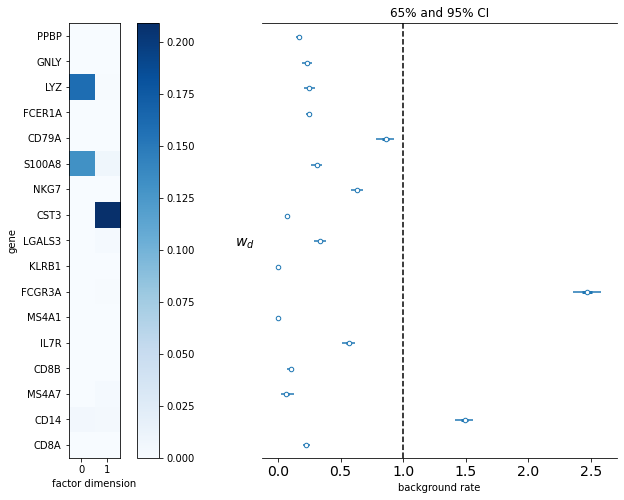

In [3]:
surrogate_samples = factor.surrogate_distribution.sample(1000)
#weights = surrogate_samples['s']/tf.reduce_sum(surrogate_samples['s'],-2,keepdims=True)

encoding_matrix=factor.encoding_matrix().numpy()

# use all genes (with makers)
topix = range(min(len(gene_names),20))

# genes with highest dispersion
# topD = 20
# topix=range(topD)

#try to extract the topD features loaded onto each latent dimension for a plot
# topD=5
# topix=[]
# for d in range(P):
#     thisix=np.argsort(encoding_matrix[:,d])[::-1][:topD]
#     topix+=thisix.tolist()


fig, ax = plt.subplots(1,2, figsize=(14,8))
pcm = ax[0].imshow(encoding_matrix[topix,:], vmin=0, cmap="Blues")
ax[0].set_yticks(np.arange(len(topix)))
ax[0].set_yticklabels(gene_names[topix])
ax[0].set_ylabel("gene")
ax[0].set_xlabel("factor dimension")
ax[0].set_xticks(np.arange(P))
ax[0].set_xticklabels(np.arange(P))

fig.colorbar(pcm, ax=ax[0], orientation = "vertical")
ID=(tf.squeeze(surrogate_samples['w'])*factor.column_norm_factor).numpy().T #*weights[:,-1,:]
ID=ID[topix,:]
intercept_data = az.convert_to_inference_data({r"$w_d$": ID})
az.plot_forest(intercept_data, ax=ax[1])
ax[1].set_xlabel("background rate")
ax[1].set_ylim((-0.014,.466))
ax[1].set_title("65% and 95% CI")
ax[1].axvline(1.0, linestyle='dashed', color="black")
plt.savefig('rnaseq_factorization.pdf', bbox_inches='tight')
plt.show()

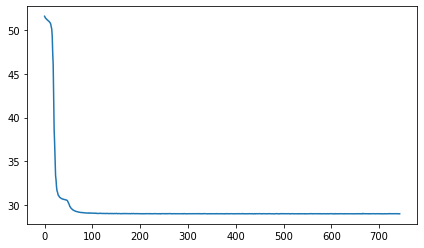

In [4]:
nploss = np.array(losses)
fig = plt.figure(figsize=(7,4))
plt.subplot(111)
plt.plot(nploss)

In [5]:
Z = factor.encode(tf.cast(next(iter(data))['data'], tf.float64))

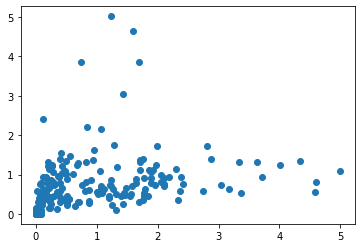

In [6]:
plt.scatter(Z[:,0], Z[:,1])

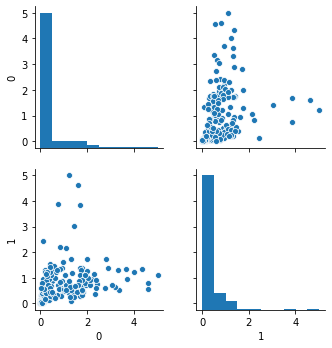

In [7]:
sns.pairplot(pd.DataFrame(Z.numpy()))